In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm, ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
import os
import argparse
from concurrent.futures import ProcessPoolExecutor, as_completed
from skimage.measure import label
import json


In [2]:
from make_frames import plot_segments_frame, plot_frame, make_frames, rand_cmap

Number of labels: 3558


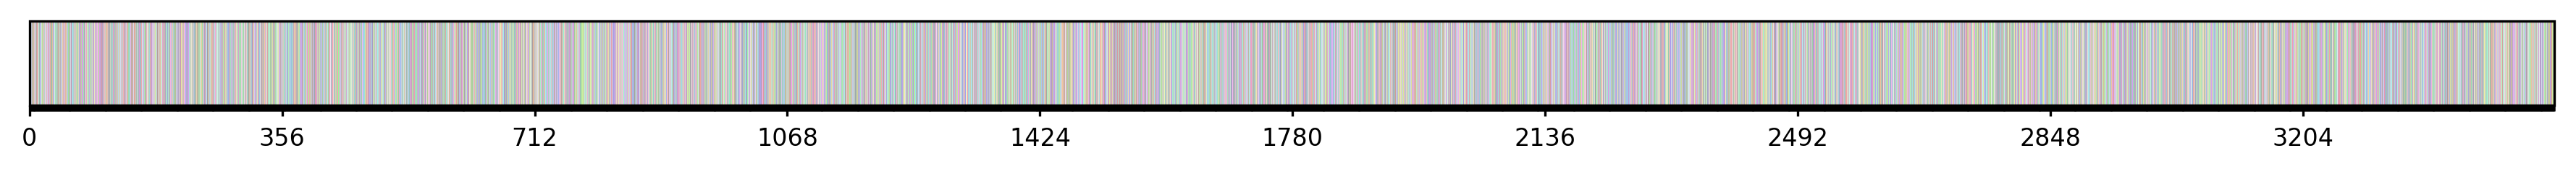

In [3]:
ds = xr.open_dataset('../../data/data_to_plot_and_animate.nc')
ds = ds.load()

cmap = rand_cmap(int(ds['segmentation'].max()))

In [4]:
ds

<xarray.Dataset> Size: 3GB
Dimensions:              (seg: 627, y: 635, bbox_coords: 4, p_coords: 2,
                          x: 26944, surface_class: 3)
Coordinates:
  * seg                  (seg) int64 5kB 0 1 2 3 4 5 ... 621 622 623 624 625 626
  * y                    (y) int64 5kB 0 1 2 3 4 5 6 ... 629 630 631 632 633 634
  * bbox_coords          (bbox_coords) int64 32B 0 1 2 3
  * p_coords             (p_coords) int64 16B 0 1
  * x                    (x) int64 216kB 0 1 2 3 4 ... 26940 26941 26942 26943
    time                 (x) datetime64[ns] 216kB 2022-04-04T13:19:30 ... 202...
Dimensions without coordinates: surface_class
Data variables: (12/17)
    segmentation         (y, x) float64 137MB 2.21e+03 2.21e+03 ... 0.0 0.0
    area                 (x, seg) float64 135MB 3.579e+03 3.209e+03 ... 9.66e+03
    bbox                 (x, seg, bbox_coords) float64 541MB 4.817e+03 ... 55.0
    predicted_iou        (x, seg) float64 135MB 1.0 0.9614 ... 0.8863 0.8793
    stability_score      (x, seg) float64 135MB 0.9839 0.9639 ... 0.9467 0.948
    point_coords         (x, seg, p_coords) float64 270MB 4.883e+03 ... 633.8
    ...                   ...
    label                (y, x) int64 137MB 1 1 1 1 ... 19519 19519 19519 19519
    BT_1                 (y, x) float32 68MB nan nan nan nan ... nan nan nan nan
    old_prediction       (y, x) int64 137MB 1 1 1 1 1 1 1 1 ... 4 4 4 4 4 4 4 4
    BT_5                 (y, x) float32 68MB nan nan nan nan ... nan nan nan nan
    BT_6                 (y, x) float32 68MB nan nan nan nan ... nan nan nan nan
    skimage_seg          (y, x) int64 137MB 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0
Attributes:
    sam_param:points_per_side:                 256
    sam_param:pred_iou_thresh:                 0.86
    sam_param:stability_score_thresh:          0.92
    sam_param:crop_n_layers:                   3
    sam_param:crop_n_points_downscale_factor:  2
    sam_param:min_mask_region_area:            100

In [10]:
def make_frames(FPS=50):
    ds = xr.open_dataset('../../data/data_to_plot_and_animate.nc')
    ds = ds.load()
    T_MIN = ds.skin_t.min().values
    T_MAX = ds.skin_t.max().values
    S_MAX = ds.segmentation.max().values
    S_MIN = ds.segmentation.min().values
    S_FINAL_MAX = ds.skimage_seg.max().values
    S_FINAL_MIN = ds.skimage_seg.min().values
    tasks = []

    cmap1 = rand_cmap(len(np.unique(ds.segmentation.values)), type='soft', first_color_black=False, last_color_black=False, verbose=False)
    #cmap2 = rand_cmap(len(np.unique(ds.skimage_seg.values)), type='soft', first_color_black=False, last_color_black=False, verbose=False)
    cmap2 = cmap1
    inpath_stump = 'showcase_v2'

    if not os.path.isdir(f'../../plots/ani/{inpath_stump}'):
        os.makedirs(f'../../plots/ani/{inpath_stump}')

    for i, x in tqdm(enumerate(ds.x.values[:-2000][::FPS]), total=len(ds.x.values[::FPS])):
        outpath = f'../../plots/ani/{inpath_stump}/frame_{i:04d}.png'
        x_slice = slice(x, x + 3000)
        tasks.append((ds, x_slice, outpath, T_MIN, T_MAX, S_MIN, S_MAX, S_FINAL_MIN, S_FINAL_MAX, cmap1, cmap2))
        #plot_frame(ds, x_slice, outpath, T_MIN, T_MAX, S_MIN, S_MAX)
    with ProcessPoolExecutor(max_workers=32) as executor:
        futures = [executor.submit(plot_segments_frame, *task) for task in tasks]
        for future in tqdm(as_completed(futures), total=len(tasks)):
            _ = future.result()
    return f'../../plots/ani/{inpath_stump}'

make_frames()

100%|██████████| 499/499 [1:03:24<00:00,  7.62s/it]


'../../plots/ani/showcase_v2'

In [9]:
ds['skimage_seg'].min()

<xarray.DataArray 'skimage_seg' ()> Size: 8B
array(0)

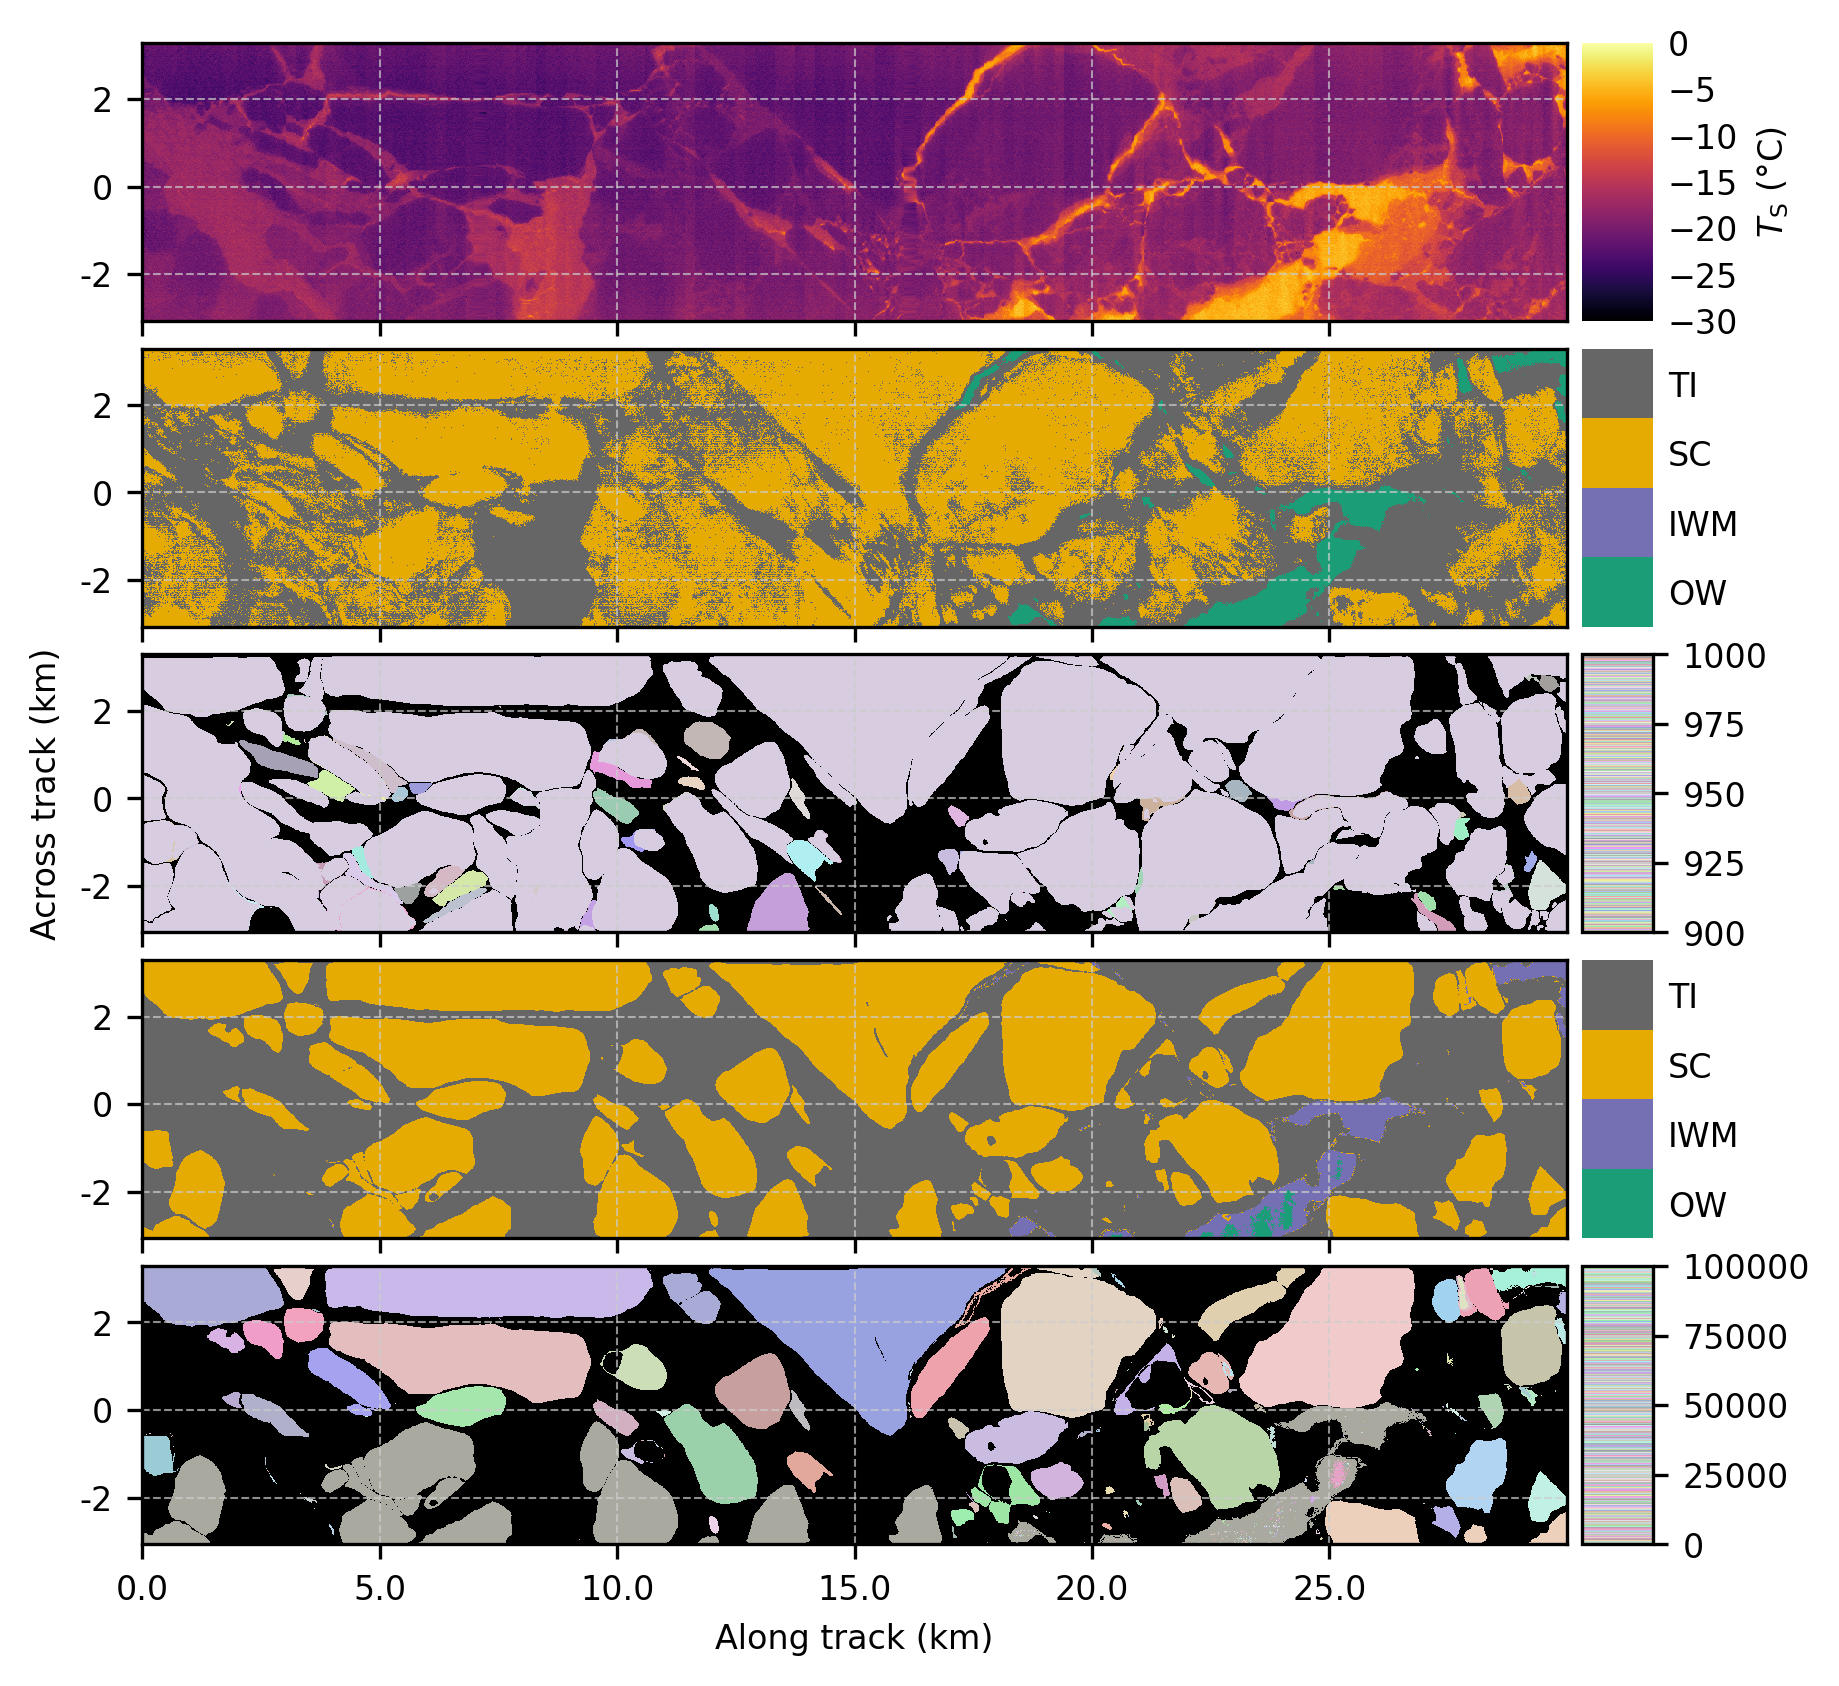

In [6]:
plot_segments_frame(ds, slice(22000, 25000), '/home/jomueller/test.png', -30, 0, 900, 1000, 0, 100000, cmap, cmap, debug=True)